In [2]:
# --------------------------------------------------------------------------------------------
# SNOTEL SWE data, QC'ed and curated by Dr. Mark Raleigh


# Import statements
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import kray
import scipy.io as sio
# OS interaction
import sys, pickle, os
# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

# --------------------------------------------------------------------------------------------
# Customize
%matplotlib inline
sns.set_context('talk')
sns.set_style('whitegrid')

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

# Directory for the SNOTEL data
dir_data = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/'
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'

## Read the SWE data from Mark

In [3]:
# Read netcdf versions of Mark's data
os.chdir(dir_data+'SNOTEL')
procSWE = xr.open_dataset('NRCS_all_daily_L3.nc')
SWEMetrics = xr.open_dataset('NRCS_snow_metrics.nc')

# Convert MATLAB datenum to numpy datetime 64
def matlabdn2datetime(matlabDatenum):
    npDatetime = [np.datetime64(datetime.fromordinal(int(dt))\
                                + timedelta(days=float(np.remainder(dt,1)))\
                                - timedelta(days = 366))\
                    for dt in matlabDatenum]        
    return(npDatetime)
snotelTime = procSWE.SERIAL_DATE
snotelTimePY = matlabdn2datetime(snotelTime)

# Convert the 'char_width_field' variables to a python string
def stringJoin(strIn,axis):
    strIn = [S.decode("utf-8") for S in strIn]
    strOut = "".join(strIn).rstrip()
    return(strOut)
stName = procSWE['STA_NAME'].groupby('nSTA').reduce(stringJoin,dim='char_field_width')
stNetwork = procSWE['STA_NETWORK'].groupby('nSTA').reduce(stringJoin,dim='char_field_width')
stState = procSWE['STA_STATE'].groupby('nSTA').reduce(stringJoin,dim='char_field_width')

# xarray Dataset
SNOTEL = xr.Dataset( {'SWE': (['nSTA','t'], procSWE['WTEQ_mm'])},
                        coords={'t': snotelTimePY})

# Additional coordinates
SNOTEL.coords['stName'] = stName
SNOTEL.coords['stNetwork'] = stNetwork
SNOTEL.coords['stState'] = stState
SNOTEL.coords['lat'] = procSWE['STA_LAT']
SNOTEL.coords['lon'] = procSWE['STA_LON']
SNOTEL.coords['elev'] = procSWE['STA_ELEV_m']
SNOTEL.coords['DOY'] = (('t'), procSWE['DOY'])

In [4]:
def water_year(time_index, last_month=9):
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xr.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year')

In [5]:
def max_SWE(swe, dim='t'):
    # Find the indicies of the max swe
    maxinds = swe.argmax(dim=dim)
    # find the index of the first day where swe < thresh
    return (swe[maxinds])

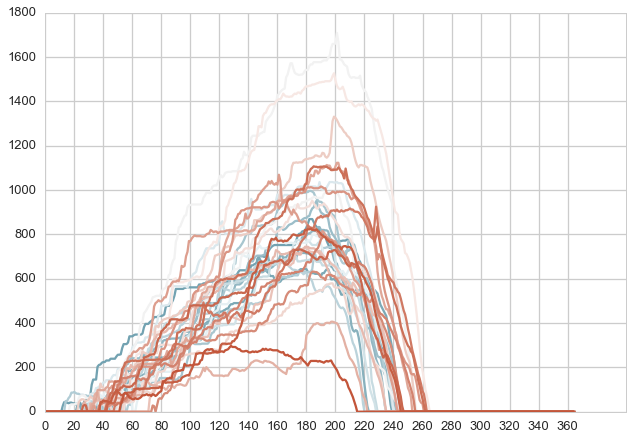

In [6]:
fig, ax = plt.subplots(1, 1)
wy = SNOTEL.groupby(water_year(SNOTEL.t))
colscheme = sns.diverging_palette(220, 20, n=len(wy.groups.keys()))

for nYear, (wYear, wYearSWE) in enumerate(wy):
    ax.plot(wYearSWE.SWE.swap_dims({'nSTA':'stName'}).sel(stName='Sasse Ridge'), color=colscheme[nYear])
ax.set_xticks(np.arange(0,366,20));

In [8]:
def noSWEChange(ds,dim='t',deltaTol=1,noSnowTol=5):
    # Defines the periods when SWE > 0 and SWE is unchanged by accumulation or melt
    indSnowPresent = ds.SWE > noSnowTol
    indSnowChange = np.absolute(S.SWE.diff(dim=dim)) < deltaTol & indSnowPresent
    return indSnowPresent, indSnowChange

def noSWEMelt(ds,dim='t',deltaTol=0,noSnowTol=0):
    # Defines the periods when SWE > 0 and SWE is unchanged by accumulation or melt
    ds['indSnowPresent'] = ds.SWE > noSnowTol
    deltaSWE = (ds.SWE.diff(dim='t') >= deltaTol).reindex_like(ds,method='nearest')
    ds['indSnowChange'] = deltaSWE & ds['indSnowPresent']
    return ds

def fracSnowDuration(ds,dim='t'):
    # Define the fraction of time with snow present during which snow did not change
    indSnowChange = ds['indSnowChange']
    indSnowPresent = ds['indSnowPresent']
    ds['fracSD'] = indSnowChange.sum(dim=dim).astype(float)/indSnowPresent.sum(dim=dim).astype(float)
    return ds

In [9]:
ds = SNOTEL#.resample(freq='H',how='mean',dim='t')
ds = noSWEMelt(ds)
ds = fracSnowDuration(ds)
print(ds)
print(ds.swap_dims({'nSTA':'stName'}).sel(stName='Grizzly Peak'))


<xarray.Dataset>
Dimensions:         (nSTA: 823, t: 13149)
Coordinates:
  * t               (t) datetime64[ns] 1979-10-01 1979-10-02 1979-10-03 ...
  * nSTA            (nSTA) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    stName          (nSTA) <U20 'Crescent Lake #1' 'Glacial Ridge' ...
    stNetwork       (nSTA) <U4 'SCAN' 'SCAN' 'SCAN' 'SCAN' 'SCAN' 'SCAN' ...
    stState         (nSTA) <U2 'MN' 'MN' 'NH' 'NH' 'NV' 'PA' 'VT' 'VT' 'AK' ...
    lat             (nSTA) float64 45.42 47.72 43.93 43.78 41.9 40.67 43.05 ...
    lon             (nSTA) float64 -93.95 -96.27 -71.72 -72.03 -119.4 -76.67 ...
    elev            (nSTA) float64 298.7 342.9 451.1 426.7 1.786e+03 222.5 ...
    DOY             (t) float64 274.0 275.0 276.0 277.0 278.0 279.0 280.0 ...
Data variables:
    SWE             (nSTA, t) float64 nan nan nan nan nan nan nan nan nan ...
    indSnowPresent  (nSTA, t) bool False False False False False False False ...
    indSnowChange   (nSTA, t) bool False False Fal

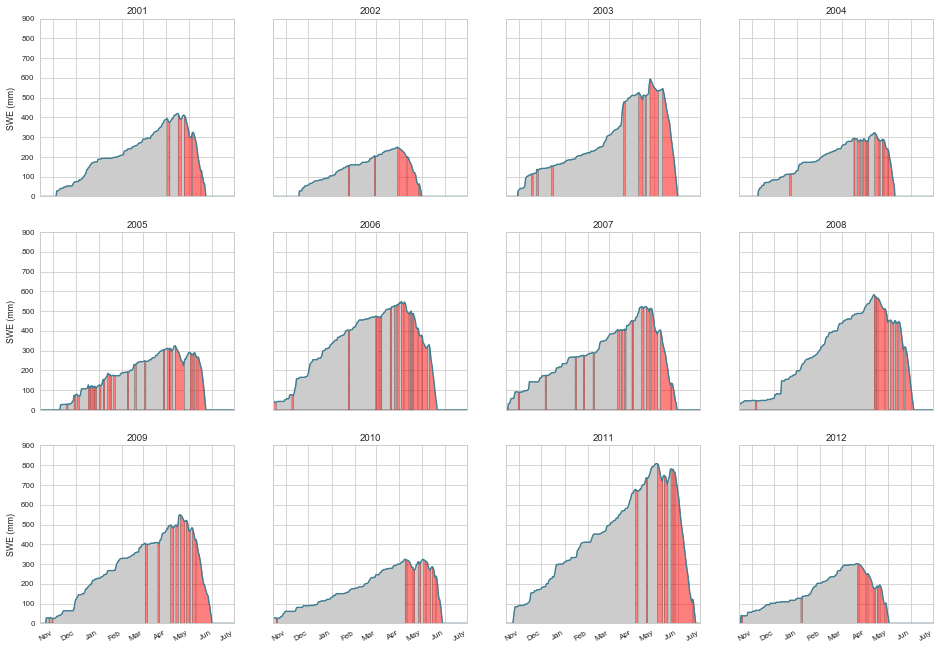

In [8]:
##### Plotting periods of no melt -- Multiple Water Years
import matplotlib.dates as mdates
monthsFmt = mdates.DateFormatter("%m")
monthLabels= ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','July']

# Grab a single station
S = ds.swap_dims({'nSTA':'stName'}).sel(stName='Grizzly Peak')
wy = S.groupby(water_year(S.t))

# Plot - mulitple water years
fig,axes = plt.subplots(3,4,figsize=(16,12),sharey=True)
axCount = 0
for wYear,wYearSWE in wy:
    if (wYear > 2000) & (wYear < 2013):
        ax = axes.flatten()[axCount]
        axCount = axCount + 1
        ax.plot(wYearSWE.t,wYearSWE.SWE)
        ax.set_xlim(datetime(wYear-1,10,15),datetime(wYear,7,1))
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
               where=wYearSWE.SWE>0,facecolor='r',alpha=.5)
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
                       where=wYearSWE.indSnowChange,facecolor=[.8,.8,.8])
        ax.set_title(str(wYear))
#         print(wYearSWE.fracSD)
        if (ax == axes[:,0]).any():
            ax.set_ylabel('SWE (mm)')
        if (ax == axes[-1,:]).any():
            ax.xaxis.set_major_formatter(monthsFmt)
            ax.set_xticklabels(monthLabels)
fig.autofmt_xdate()

<xarray.DataArray 'fracSD' ()>
array(0.8317435082140965)
Coordinates:
    nSTA       int64 136
    stName     <U12 'Grizzly Peak'
    stNetwork  <U4 'SNTL'
    stState    <U2 'CO'
    lat        float64 39.65
    lon        float64 -105.9
    elev       float64 3.383e+03


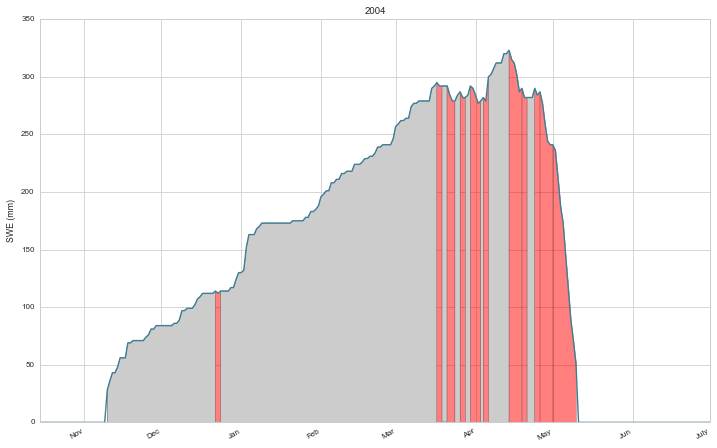

In [9]:
##### Plotting periods of no melt -- Single Water Year
import matplotlib.dates as mdates
monthsFmt = mdates.DateFormatter("%m")
monthLabels= ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','July']

# Grab a single station
S = ds.swap_dims({'nSTA':'stName'}).sel(stName='Grizzly Peak')
wy = S.groupby(water_year(S.t))

# Plot - mulitple water years
fig,ax = plt.subplots(1,1,figsize=(12,8))
for wYear,wYearSWE in wy:
    if wYear == 2004:
        ax.plot(wYearSWE.t,wYearSWE.SWE)
        ax.set_xlim(datetime(wYear-1,10,15),datetime(wYear,7,1))
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
               where=wYearSWE.SWE>0,facecolor='r',alpha=.5)
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
                       where=wYearSWE.indSnowChange,facecolor=[.8,.8,.8])
        ax.set_title(str(wYear))
        ax.set_ylabel('SWE (mm)')
        ax.xaxis.set_major_formatter(monthsFmt)
        ax.set_xticklabels(monthLabels)        
        print(wYearSWE.fracSD)

fig.autofmt_xdate()

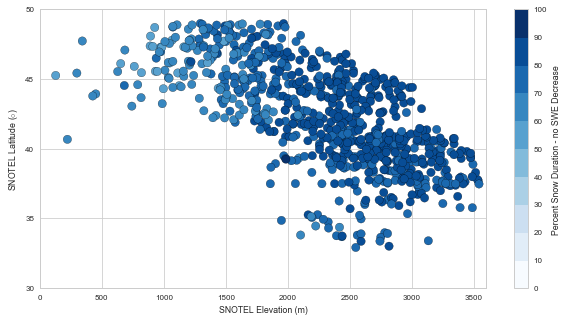

In [10]:
cmap = kgraph.cmap_discretize(cm.Blues,10)

## Figure of % time with no SWE change (either accumulation or ablation)
# fig,ax = plt.subplots(1,1,figsize=(10,5))
# SnoChange = noSWEChange(SNOTEL)
# cax = ax.scatter(SNOTEL['elev'],SNOTEL['lat'],s=70,c=SnoChange.mean('t')*100,vmin=0,vmax=35,cmap=cmap)
# ax.set_ylim(30,50)
# ax.set_xlim(0,3600)
# ax.set_ylabel('SNOTEL Latitude ($\circ$)')
# ax.set_xlabel('SNOTEL Elevation (m)')
# cbar = fig.colorbar(cax)
# cbar.ax.set_ylabel('Percent time - no SWE change')

## Figure of % time with no SWE melt (just negative SWE changes)
fig,ax = plt.subplots(1,1,figsize=(10,5))
cax = ax.scatter(ds['elev'],ds['lat'],s=70,c=ds['fracSD']*100,vmin=0,vmax=100,cmap=cmap)
ax.set_ylim(30,50)
ax.set_xlim(0,3600)
ax.set_ylabel('SNOTEL Latitude ($\circ$)')
ax.set_xlabel('SNOTEL Elevation (m)')
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel('Percent Snow Duration - no SWE Decrease')

## Figure of % time with no SWE melt (just negative SWE changes)
# fig,ax = plt.subplots(1,1,figsize=(10,5))
# SnoMelt = noSWEMelt(SNOTEL)
# cax = ax.scatter(SNOTEL['elev'],SNOTEL['lat'],s=70,\
#                  c=SnoMelt.groupby(water_year(SnoMelt.t)).mean('t').max(dim='water_year')*100,\
#                  vmin=0,vmax=70,cmap=cmap)
# ax.set_ylim(30,50)
# ax.set_xlim(0,3600)
# ax.set_ylabel('SNOTEL Latitude ($\circ$)')
# ax.set_xlabel('SNOTEL Elevation (m)')
# cbar = fig.colorbar(cax)
# cbar.ax.set_ylabel('Percent time - no SWE Decrease (max by water year)')

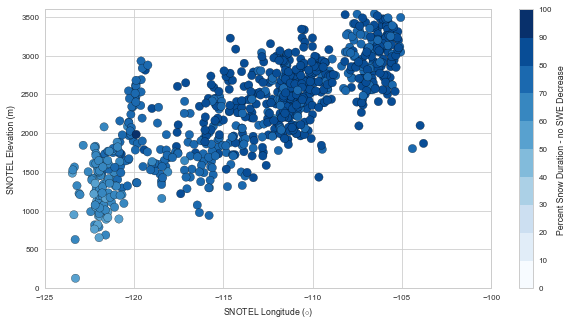

In [11]:
## Figure of % time with no SWE melt (just negative SWE changes)
cmap = kgraph.cmap_discretize(cm.Blues,10)
fig,ax = plt.subplots(1,1,figsize=(10,5))
cax = ax.scatter(ds['lon'],ds['elev'],s=70,c=ds['fracSD']*100,vmin=0,vmax=100,cmap=cmap)
ax.set_xlim(-125,-100)
ax.set_ylim(0,3600)
ax.set_xlabel('SNOTEL Longitude ($\circ$)')
ax.set_ylabel('SNOTEL Elevation (m)')
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel('Percent Snow Duration - no SWE Decrease')


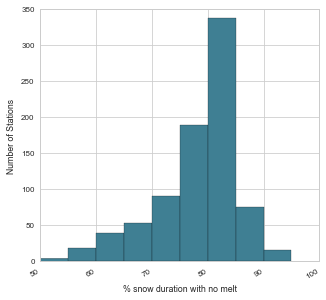

In [12]:
## Histogram of station melt percent
fig,ax = plt.subplots(1,1,figsize=(5,5))
n, bins, patches = plt.hist(ds.fracSD*100.,np.arange(0.5,1.,.05)*100)

# Format
ax.set_xlabel('% snow duration with no melt')
ax.set_ylabel('Number of Stations')
fig.autofmt_xdate()


0.8317435082140965


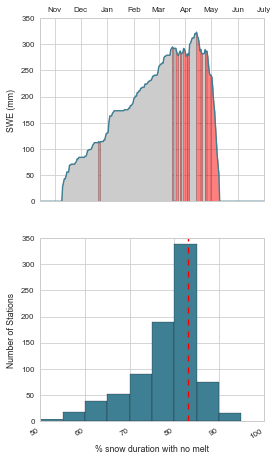

In [13]:
fig,axes = plt.subplots(2,1,figsize=(4,8))

## Histogram of station melt percent
ax = axes[1]
n, bins, patches = ax.hist(ds.fracSD*100.,np.arange(0.5,1.,.05)*100)
ax.plot(np.array((wYearSWE.fracSD.values*100,wYearSWE.fracSD.values*100)),np.array((0,350)),'r--')

# Format
ax.set_xlabel('% snow duration with no melt')
ax.set_ylabel('Number of Stations')
fig.autofmt_xdate()

## Plotting periods of no melt -- Single Water Year
ax = axes[0]
monthsFmt = mdates.DateFormatter("%m")
monthLabels= ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','July']

# Grab a single station
S = ds.swap_dims({'nSTA':'stName'}).sel(stName='Grizzly Peak');
wy = S.groupby(water_year(S.t));

# Plot - mulitple water years
for wYear,wYearSWE in wy:
    if wYear == 2004:
        ax.plot(wYearSWE.t,wYearSWE.SWE)
        ax.set_xlim(datetime(wYear-1,10,15),datetime(wYear,7,1))
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
               where=wYearSWE.SWE>0,facecolor='r',alpha=.5)
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
                       where=wYearSWE.indSnowChange,facecolor=[.8,.8,.8])
        ax.set_ylabel('SWE (mm)')
        ax.xaxis.set_major_formatter(monthsFmt)
        ax.set_xticklabels(monthLabels)        
        ax.xaxis.tick_top()

        print(wYearSWE.fracSD.values)

os.chdir(dirPrint)
fig.savefig('WSC2016.Figure1.MeltFracSD.pdf')

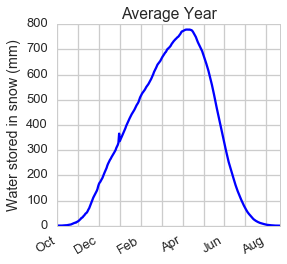

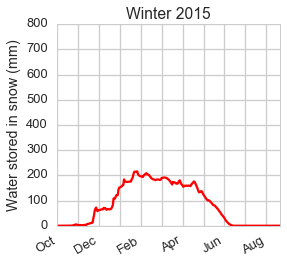

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
# Average year
ax.plot(SNOTEL.swap_dims({'nSTA':'stState'}).sel(stState='WA').mean(dim='stState').\
        groupby('DOY').mean().SWE.roll(DOY=90),
        color='b', label='Average year')
ax.set_ylabel('Water stored in snow (mm)')
ax.set_xticks(np.arange(0, 330, 30))
ax.set_xticklabels(['Oct', '', 'Dec', '', 'Feb', '', 'Apr', '', 'Jun', '', 'Aug', ''])
ax.set_xlim(0, 320)
ax.set_ylim(0, 800)
ax.set_title('Average Year')
fig.autofmt_xdate()

os.chdir('/Users/karllapo/gdrive/SnowHydrology/Documents/Outreach/Carbon WA')
fig.savefig('CarbonWA.NormalSnowYear.pdf')

# WY 2015
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.plot(SNOTEL.swap_dims({'nSTA':'stState'}).sel(stState='WA').mean(dim='stState').\
        loc[dict(t=slice(datetime(2014, 10, 1), datetime(2015, 9, 30)))].SWE,
        color='r', label='2015')
ax.set_ylabel('Water stored in snow (mm)')
ax.set_xticks(np.arange(0, 330, 30))
ax.set_xticklabels(['Oct', '', 'Dec', '', 'Feb', '', 'Apr', '', 'Jun', '', 'Aug', ''])
ax.set_xlim(0, 320)
ax.set_ylim(0, 800)
ax.set_title('Winter 2015')
fig.autofmt_xdate()
fig.savefig('CarbonWA.2015SnowYear.pdf')



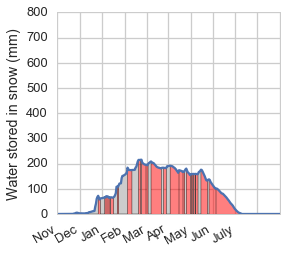

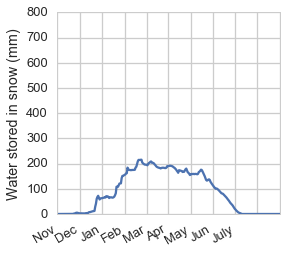

In [58]:
os.chdir(dirPrint)
import matplotlib.dates as mdates
monthsFmt = mdates.DateFormatter("%m")
monthLabels= ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','July']

# WY 2015
WY2015 = SNOTEL.swap_dims({'nSTA':'stState'}).sel(stState='WA').mean(dim='stState').\
        loc[dict(t=slice(datetime(2014, 10, 1), datetime(2015, 9, 30)))]
WY2015 = noSWEMelt(WY2015)
WY2015 = fracSnowDuration(WY2015)

# Highlight Melt
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.plot(WY2015.t, WY2015.SWE, label='2015')
ax.fill_between(WY2015.t.values, 0, WY2015.SWE,
                where=WY2015.SWE > 0, facecolor='r', alpha=.5)
ax.fill_between(WY2015.t.values, 0, WY2015.SWE,
               where=WY2015.indSnowChange,facecolor=[.8,.8,.8])

ax.xaxis.set_major_formatter(monthsFmt)
ax.set_xticklabels(monthLabels)
ax.set_xlim(datetime(2014, 10, 1), datetime(2015, 8, 1))
ax.set_ylabel('Water stored in snow (mm)')
ax.set_ylim(0, 800)
fig.autofmt_xdate()
fig.savefig('CarbonWA.2015SnowYear.Melt.pdf')

# Just the SWE curve
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.plot(WY2015.t, WY2015.SWE, label='2015')

ax.xaxis.set_major_formatter(monthsFmt)
ax.set_xticklabels(monthLabels)
ax.set_xlim(datetime(2014, 10, 1), datetime(2015, 8, 1))
ax.set_ylabel('Water stored in snow (mm)')
ax.set_ylim(0, 800)
fig.autofmt_xdate()
fig.savefig('CarbonWA.2015SnowYear.NoFill.pdf')

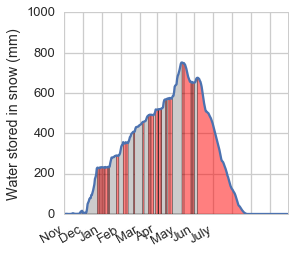

In [55]:
year = 2009
d1 = datetime(year, 10, 1)
d2 = datetime(year + 1, 9, 30)
import matplotlib.dates as mdates
monthsFmt = mdates.DateFormatter("%m")
monthLabels= ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','July']

# WY 2015
WY2015 = SNOTEL.swap_dims({'nSTA':'stState'}).sel(stState='WA').mean(dim='stState').\
        loc[dict(t=slice(d1, d2))]
WY2015 = noSWEMelt(WY2015)
WY2015 = fracSnowDuration(WY2015)


fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.plot(WY2015.t, WY2015.SWE, label='2015')
ax.fill_between(WY2015.t.values, 0, WY2015.SWE,
                where=WY2015.SWE > 0, facecolor='r', alpha=.5)
ax.fill_between(WY2015.t.values, 0, WY2015.SWE,
               where=WY2015.indSnowChange,facecolor=[.8,.8,.8])

ax.xaxis.set_major_formatter(monthsFmt)
ax.set_xticklabels(monthLabels)
ax.set_xlim(d1, d2)
ax.set_ylabel('Water stored in snow (mm)')
ax.set_ylim(0, 1000)
fig.autofmt_xdate()
fig.savefig('CarbonWA.2015SnowYear.Melt.pdf')

In [36]:
normalWY


<xarray.Dataset>
Dimensions:         (DOY: 366)
Coordinates:
  * DOY             (DOY) float64 277.0 278.0 279.0 280.0 281.0 282.0 283.0 ...
Data variables:
    indSnowPresent  (DOY) bool True True True True True True True True True ...
    indSnowChange   (DOY) bool True True True True True True True True True ...
    SWE             (DOY) float64 0.5822 0.5468 0.4403 0.4831 0.4465 0.557 ...
    fracSD          (DOY) float64 0.6622 0.6622 0.6622 0.6622 0.6622 0.6622 ...